The following notebook records the process behind the construction of an upcoming choropleth data visualization of New York City real estate types.

# Inspiration

The inspiration for this post is a [popular London residential property sales visualization](https://www.reddit.com/r/dataisbeautiful/comments/4m0y4y/london_mapped_by_residential_property_sales_oc_cp/) that was posted to the DataIsBeautiful subreddit a few days ago.

I quite liked the visualization and thought that, given my recent work with real estate in another large global city, New York City, it would be worthwhile for me to recreate it.

# Data

My home institution, CUNY Baruch College, has a geospatial team, and one of the datasets that the folks there put together was a parsing of the New York City real estate sales data called the [Geocoded Real Estate Sales Dataset](https://www.baruch.cuny.edu/confluence/display/geoportal/NYC+Geocoded+Real+Estate+Sales). This contains a geocoded record of all real estate sales in New York City going back to 2003.

# Design initialization

I bookmarked an impressive-looking d3.js mapping extension called [Spam](https://github.com/newsappsio/spam) recently on GitHub, and even though the inspiration for this project was static, this seems like a perfect opportunity to try out a new interactive library. I also considered using matplotlib's static Basemap package, but Spam is more forward-thinking so I decided to go that way.

I envisioned coming up with a set of n (probably 4, but possibly more) hoverable choropleths that I can then combine at the end into a single publication-quality graphic design (that I could maybe print and hang up on my wall!).

There are plenty of different NYC geographic breakdowns, but given the depth of our dataset the most detailed one, the [2010 Census tracts](https://github.com/dwillis/nyc-maps/blob/master/census_tracts_2010.geojson), seemed appropriate.

# Technical preperations

All of the data processing that I did for this project is contained in this notebook. I used a `conda` virtual environment on my Desktop PC called `nyc-real-estate-sales` to isolate the packages I needed, which involved a couple of technical hickups:

* `pyproj`, a library that I need for converting Long Island State Grid coordinates to global coordinates, failed to install on my PC. Neither `pip` nor `conda` nor `easy_install` could handle it, due to some Visual Studio dependencies that the library couldn't trace. I got it working by following the advice contained the top answer to [this StackOverflow question](http://stackoverflow.com/questions/37521682/error-installing-pyproj-in-python-3-5) and wheel-installing into the virtual environment.
* `sqlite3`, the database software that I needed in order to use the data files that the school provided me with, doesn't come installed by default on Windows. I tried out and have really fallen in love with `brew` on Mac OSX, surely there's a Windows equivalent? Yes! I installed [Chocolatey](https://chocolatey.org/) and got things running that way with `choco install sqlite.shell` to get the `sqlite3` shell up and running.

# Design finalization

Building on my previous experiences I wanted to get a thorough grasp on the data before I finalized the design.

The data is distributed as a series of files of the form `yr_2015`, `yr_2014`, etc., going back to `yr_2013` (discovered with `.tables`.). Running a `.schema yr_2015`:

    CREATE TABLE "yr_2015" ("sale_id" TEXT PRIMARY KEY  NOT NULL ,"
    year" TEXT,"borough" INTEGER,"nbhd" TEXT,"bldg_ctgy" TEXT,"tax_
    k" TEXT,"lot" TEXT,"easmnt" TEXT,"bldg_cls_p" TEXT,"address" TE
    p" TEXT,"res_unit" INTEGER,"com_unit" INTEGER,"tot_unit" INTEGE
    EGER,"tot_sqft" INTEGER,"yr_built" INTEGER DEFAULT (null) ,"tax

Gave me the idea for the query to run to get building class:

    sqlite> SELECT DISTINCT bldg_ctgy FROM yr_2015;
    01  ONE FAMILY DWELLINGS
    02  TWO FAMILY DWELLINGS
    03  THREE FAMILY DWELLINGS
    05  TAX CLASS 1 VACANT LAND
    07  RENTALS - WALKUP APARTMENTS
    08  RENTALS - ELEVATOR APARTMENTS
    09  COOPS - WALKUP APARTMENTS
    10  COOPS - ELEVATOR APARTMENTS
    21  OFFICE BUILDINGS
    22  STORE BUILDINGS
    27  FACTORIES
    29  COMMERCIAL GARAGES
    30  WAREHOUSES
    31  COMMERCIAL VACANT LAND
    32  HOSPITAL AND HEALTH FACILITIES
    41  TAX CLASS 4 - OTHER
    06  TAX CLASS 1 - OTHER
    35  INDOOR PUBLIC AND CULTURAL FACILITIES
    04  TAX CLASS 1 CONDOS
    14  RENTALS - 4-10 UNIT
    17  CONDO COOPS
    33  EDUCATIONAL FACILITIES
    37  RELIGIOUS FACILITIES
    43  CONDO OFFICE BUILDINGS

Examining the visualization I saw several interesting simplifying assumptions that a visualization of this type makes:
* We are interested only in residential real estate. We ignore commercial stock.
* We are interested only in the percentage composition of the housing stock in each neighborhood, not their absolute number.

Examining this list I saw several flags:
* Maps that are on a by-property basis (the [PropertyShark](http://www.propertyshark.com/mason/ny/New-York-City/Maps?map=nyc2&x=0.6533333333333333&y=0.5&zoom=0&basemap=buildclass&tab=themes&ll=40.7130630998563,-73.8691790385263) one in particular) include information on "mixed-use buildings" in Manhattan which are impossible parse for our chosen perspective. This column does not contain them.
* What is a Condo Coop?

I will look into this once I localize the data.

Examining the PropertyShark map I decided to provisionally take four categories:
* ONE FAMILY DWELLINGS (single-family dwellings)
* TWO FAMILY/THREE FAMILY DWELLINGS (multi-family dwellings)
* WALKUPS (walk-up apartments)
* ELEVATOR (elevator apartments)

Notice that I am not taking a stake in condos-versus-co ops-versus-rentals!

In [1]:
import sqlite3
import pandas as pd

In [2]:
conn = sqlite3.connect('nyc_real_estate_sales.sqlite')
c = conn.cursor()

In [263]:
data = pd.concat([pd.read_sql('SELECT address, long, lat, bldg_ctgy FROM yr_2015;', conn),
                  pd.read_sql('SELECT address, long, lat, bldg_ctgy FROM yr_2014;', conn),
                  pd.read_sql('SELECT address, long, lat, bldg_ctgy FROM yr_2013;', conn),
                  pd.read_sql('SELECT address, long, lat, bldg_ctgy FROM yr_2012;', conn),
                  pd.read_sql('SELECT address, long, lat, bldg_ctgy FROM yr_2011;', conn),
                  pd.read_sql('SELECT address, long, lat, bldg_ctgy FROM yr_2010;', conn),
                 ])
# sql_str = 'SELECT address, long, lat, bldg_ctgy FROM {X};'
# data = pd.concat([pd.read_sql(, conn), pd.read_sql('SELECT address, long, lat, bldg_ctgy FROM yr_2015;', conn)]

In [264]:
# Multi-year ratios.
data['bldg_ctgy'].value_counts() / data['bldg_ctgy'].value_counts().sum()

13  CONDOS - ELEVATOR APARTMENTS               0.154839
10  COOPS - ELEVATOR APARTMENTS                0.142004
01  ONE FAMILY DWELLINGS                       0.098455
02  TWO FAMILY DWELLINGS                       0.090826
01  ONE FAMILY HOMES                           0.086100
02  TWO FAMILY HOMES                           0.079682
07  RENTALS - WALKUP APARTMENTS                0.045981
28  COMMERCIAL CONDOS                          0.029188
09  COOPS - WALKUP APARTMENTS                  0.027949
03  THREE FAMILY DWELLINGS                     0.026788
03  THREE FAMILY HOMES                         0.023178
45  CONDO HOTELS                               0.018720
25  LUXURY HOTELS                              0.017308
04  TAX CLASS 1 CONDOS                         0.016545
05  TAX CLASS 1 VACANT LAND                    0.014271
15  CONDOS - 2-10 UNIT RESIDENTIAL             0.013588
22  STORE BUILDINGS                            0.013221
12  CONDOS - WALKUP APARTMENTS                 0

In [262]:
# Single-year ratios.
data['bldg_ctgy'].value_counts() / data['bldg_ctgy'].value_counts().sum()

01  ONE FAMILY DWELLINGS                       0.189093
02  TWO FAMILY DWELLINGS                       0.169557
10  COOPS - ELEVATOR APARTMENTS                0.157170
13  CONDOS - ELEVATOR APARTMENTS               0.140147
03  THREE FAMILY DWELLINGS                     0.048155
07  RENTALS - WALKUP APARTMENTS                0.047589
45  CONDO HOTELS                               0.034176
09  COOPS - WALKUP APARTMENTS                  0.032677
17  CONDO COOPS                                0.017011
04  TAX CLASS 1 CONDOS                         0.016822
44  CONDO PARKING                              0.015442
26  OTHER HOTELS                               0.014251
05  TAX CLASS 1 VACANT LAND                    0.013213
15  CONDOS - 2-10 UNIT RESIDENTIAL             0.012988
22  STORE BUILDINGS                            0.012764
29  COMMERCIAL GARAGES                         0.010134
14  RENTALS - 4-10 UNIT                        0.008706
12  CONDOS - WALKUP APARTMENTS                 0

* `lat` and `long` came already rekeyed for global coordinates, a welcome surprise!
* A `CONDO HOTEL` is a hotel which operates its units as a condominium ([source](https://en.wikipedia.org/wiki/Condo_hotel)) (so when you buy the hotel you buy a lot of individual units?). We can ignore it.
* `TAX CLASS 1 CONDOS` consists of residential properties of up to three units, but no more. This categorization does not tell us whether the apartment is an elevator or walk-up building, but we can assume that it is a walk-up from the low unit count. This categorization does not tell us whether it is a detached building, and thus more akin to a multi-family home, or an attached building, more akin the a walk-up apartment. But they are structured like an apartment so I put them in walk-up apartments.
* `CONDO CO OPS` are buildings containing units which are both condominiums owned by one organization and co-ops owned by another. All are apartments and *almost* all are huge. The vast majority are extremely large apartment blocks in Manhattan. A few are in Queens and/or Brooklyn and also appear to all be huge. Shoehoring these into elevator apartments is acceptable as the number of these is fairly small and the error rate for doing so it `<5%` at most.
* `RENTALS - 4-10 UNIT` is for the sale of small rental buildings (not apartments). Others similar. We exclude.
* `CONDO PARKING` is literal parking.
* `CONDO OFFICE BUILDINGS` are those little lots where you have one building with a lot of little stores in them. Interesting!

Another concern must be noted. We are using records of city sales going back to 2003; but did the classification system used for the dataset stay the same throughout all those years? The answer appears to be "no".

The following exceptions have been noted: 

* Condo co-ops were previously known by the apparently more technically well-known but less immediately informative term [condops](https://en.wikipedia.org/wiki/Condop), taking the same number slot (`17`) in the index. To extend this data back, then, before 2015, we need to include that categorization in our considerations. Luckily this is easily handled by adding `'17  CONODOPS'` to our checklist.
* Similarly, previous years also had categories for `ONE FAMILY HOMES`, `TWO FAMILY HOMES`, and `THREE FAMILY HOMES`. These have been renamed to `DWELLINGS` more recently.

We can now consolidate the data.

In [265]:
single_family = data[data['bldg_ctgy'].map(lambda x: x in ['01  ONE FAMILY DWELLINGS', '01  ONE FAMILY HOMES'])]

In [266]:
multi_family = data[data['bldg_ctgy'].map(lambda x: x in ['02  TWO FAMILY DWELLINGS', '03  THREE FAMILY DWELLINGS', '02  TWO FAMILY HOMES', '03  THREE FAMILY HOMES'])]

In [267]:
elevator_apartments = data[data['bldg_ctgy'].map(lambda x: x in ['10  COOPS - ELEVATOR APARTMENTS', '08  RENTALS - ELEVATOR APARTMENTS', '13  CONDOS - ELEVATOR APARTMENTS', '17  CONDO COOPS', '17  CONODOPS'])]

In [268]:
walkups = data[data['bldg_ctgy'].map(lambda x: x in ['07  RENTALS - WALKUP APARTMENTS', '09  COOPS - WALKUP APARTMENTS', '12  CONDOS - WALKUP APARTMENTS', '04  TAX CLASS 1 CONDOS'])]

In [222]:
# b_dfs = [single_family, multi_family, elevator_apartments, walkups]

I need to verify that the sales numbers are large enough to be useable at the chosen level of resolution.

In [10]:
import matplotlib.pyplot as plt
import mplleaflet

In [11]:
%matplotlib inline

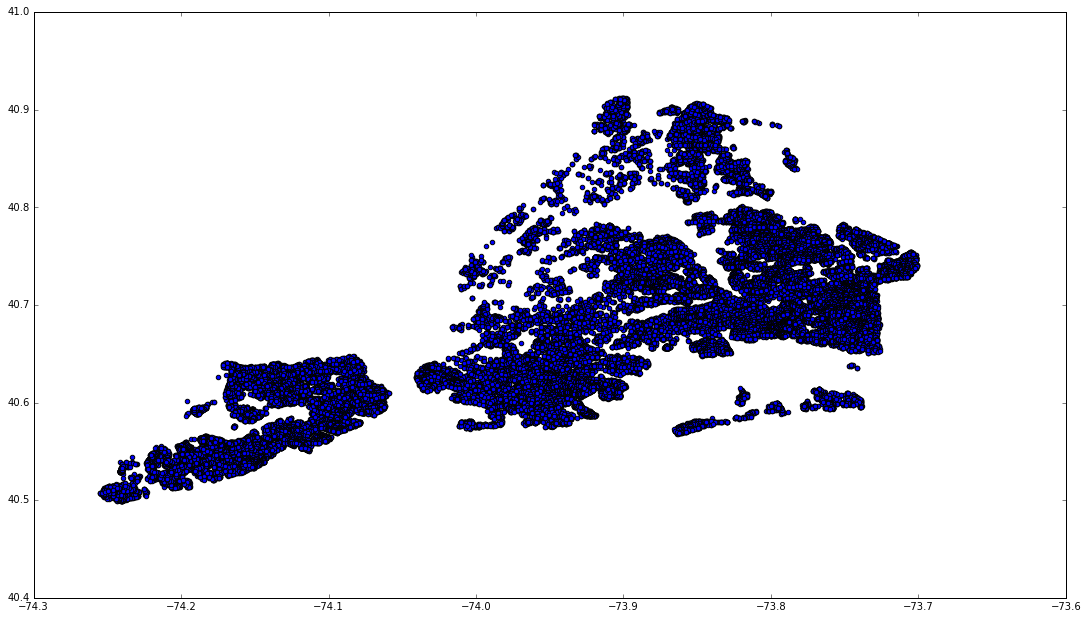

In [269]:
plt.scatter(single_family['long'], single_family['lat'])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
# mplleaflet.show()
plt.show()

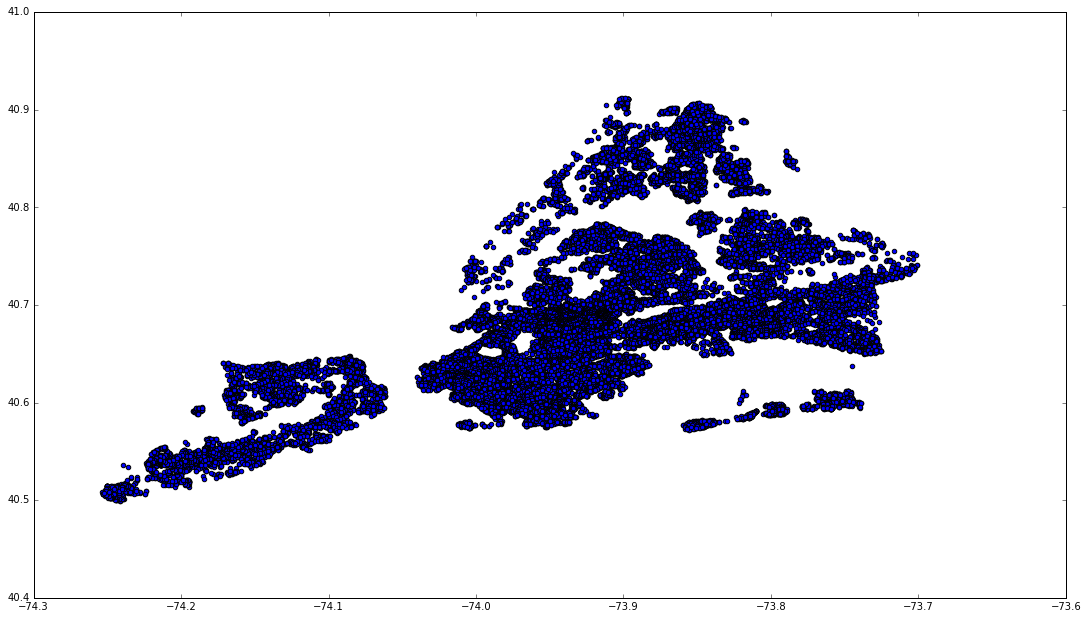

In [225]:
plt.scatter(multi_family['long'], multi_family['lat'])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
# mplleaflet.show()
plt.show()

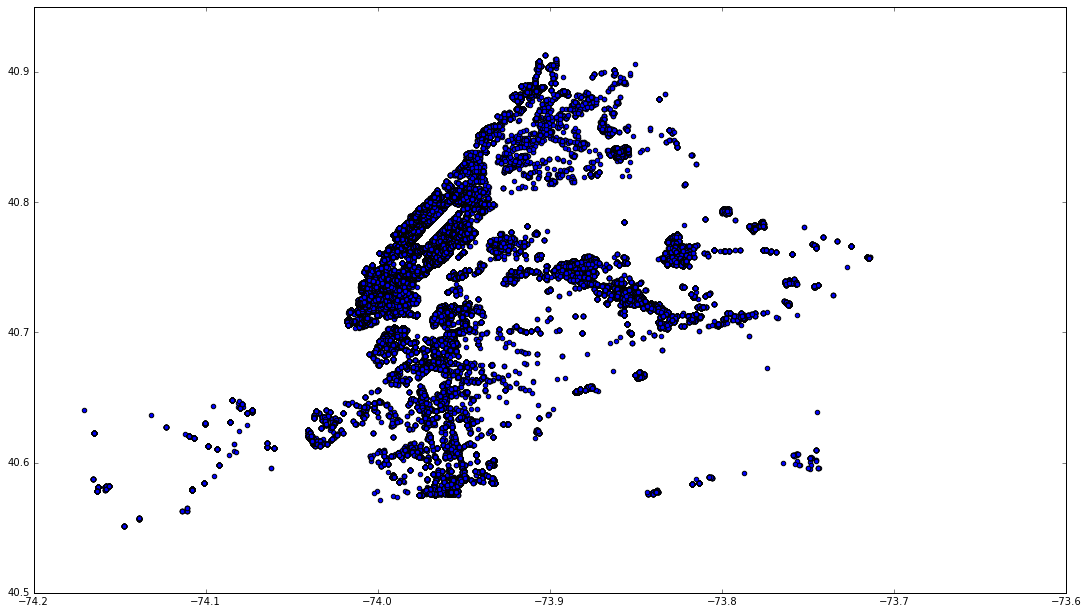

In [270]:
plt.scatter(elevator_apartments['long'], elevator_apartments['lat'])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
# mplleaflet.show()
plt.show()

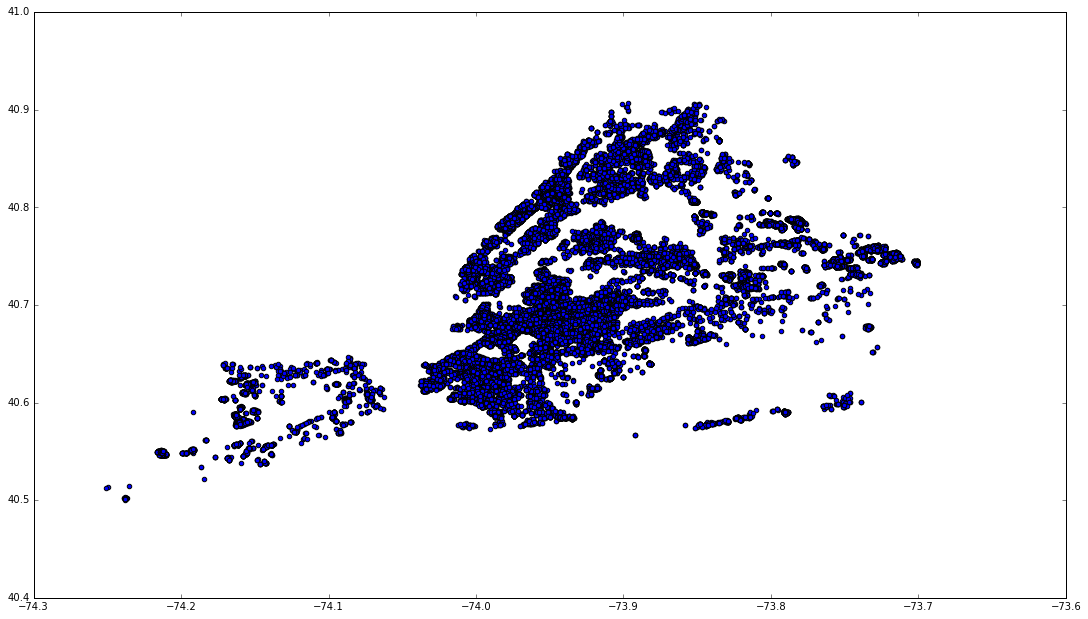

In [271]:
plt.scatter(walkups['long'], walkups['lat'])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
# mplleaflet.show()
plt.show()

Wow, there is a *very* interesting texture to this data!

# Data processing

At this point I want to generate a geojson file where I associate each polygonal segment with the computed percentages for the segment. This is where all of the heavy lifting is.

In [16]:
import geojson

The geography I use is the census tracts 2010 data from [nyc-maps](https://github.com/dwillis/nyc-maps).

In [17]:
%ls

 Volume in drive C is SSD_80GB
 Volume Serial Number is 9279-00B2

 Directory of C:\Users\Alex\Desktop\nyc-real-estate-sales

06/03/2016  11:24 AM    <DIR>          .
06/03/2016  11:24 AM    <DIR>          ..
06/03/2016  11:10 AM                48 .gitignore
06/03/2016  11:18 AM    <DIR>          .ipynb_checkpoints
06/02/2016  08:27 PM             1,379 _map.html
06/02/2016  09:20 PM           853,644 census_tracts_2010.geojson
06/03/2016  11:20 AM        20,481,560 census_tracts_2010_converted.geojson
06/02/2016  04:31 PM       382,435,328 nyc_real_estate_sales.sqlite
06/02/2016  05:03 PM         3,183,875 pyproj-1.9.5.1-cp35-cp35m-win_amd64.whl
06/03/2016  11:24 AM           676,277 Untitled.ipynb
               7 File(s)    407,632,111 bytes
               3 Dir(s)   6,615,674,880 bytes free


In [183]:
# geo = geojson.loads(open('census_tracts_2010.geojson', 'r').read())

This geography is encoded as a topojson, so I need to be able to stitch arcs and convert them to coordinates.

The following function partially handles this problem, based on a reading of the [official spec](https://github.com/mbostock/topojson-specification). However it's incomplete, it doesn't account for holes, doesn't handle ones' compliment negative indexing notation, path coordinate reversal (winding clockwise? counterclockwise?), and incorrectly handles rolling forward distances.

In [51]:
# def globalize(geo):
#     long_scale_factor, lat_scale_factor = geo['transform']['scale']
#     long_translate_factor, lat_translate_factor = geo['transform']['translate']
#     arc_lists = [poly['arcs'][0] for poly in geo['objects']['nyct2010']['geometries']]
#     coordinate_arc_lists = []
#     for arc_list in arc_lists:
#         # print(arc_list)
#         coordinate_arc_list = []
#         for arc_index_candidate in arc_list:
#             if isinstance(arc_index_candidate, int):
#                 print(arc_index_candidate)
#                 coordinate_arc = [(long_scale_factor*long + long_translate_factor, lat_scale_factor*lat + lat_translate_factor) for lat, long in geo['arcs'][arc_index_candidate]]
#                 print(coordinate_arc)
#                 coordinate_arc_list += coordinate_arc
#             else:
#                 for arc_index in arc_index_candidate:
#                     coordinate_arc = [(long_scale_factor*long + long_translate_factor, lat_scale_factor*lat + lat_translate_factor) for lat, long in geo['arcs'][arc_index]]
#                     coordinate_arc_list += coordinate_arc
#         print(coordinate_arc_list)
#         # break
#         return coordinate_arc_list
#         coordinate_arc_lists.append(coordinate_arc_list)
#     return coordinate_arc_lists

In [20]:
# ca = [(-74.06161818558394, 40.62375686860938), (-74.25520241730598, 40.49670263822828), (-74.25520241730598, 40.49670263822828), (-74.25520241730598, 40.49674458416106), (-74.25453565186952, 40.497667394682146), (-74.25503572594687, 40.49590566550552), (-74.2553691086651, 40.497667394682146), (-74.25742496876089, 40.496912367892165)]
# plt.scatter([c[0] for c in ca], [c[1] for c in ca])
# fig = plt.gcf()
# fig.set_size_inches(18.5, 10.5)
# # mplleaflet.show()
# plt.show()

Better idea: someone else has already done all of this work. I threw the TopoJSON at a GeoJSON<->TopoJSON converter which functions both ways [here](http://jeffpaine.github.io/geojson-topojson/). I then saved the file locally as `census_tracts_2010_converted.geojson`. The resulting file is `20,002 KB` in size! Versus the `834 KB` of the original.

In [504]:
geo = geojson.loads(open('census_tracts_2010_converted.geojson', 'r').read())

In [31]:
# list_of_polygons = [feature['geometry']['coordinates'][0] for feature in geo['features']]

I need a point-in-polygon algorithm.

In [50]:
# # Borrowed from: http://www.ariel.com.au/a/python-point-int-poly.html
# def point_inside_polygon(x, y, poly):
#     """
#     Checks if a point is inside a polygon.
#     Used to validate points as being inside of Manahttan.
#     Borrowed from: http://www.ariel.com.au/a/python-point-int-poly.html
    
#     The shapely library provides features for this and other things besides, but is too much to deal with at the moment.
#     """

#     n = len(poly)
#     inside = False

#     print(poly[0])
#     p1x,p1y = poly[0]
#     for i in range(n+1):
#         p2x,p2y = poly[i % n]
#         if y > min(p1y,p2y):
#             if y <= max(p1y,p2y):
#                 if x <= max(p1x,p2x):
#                     if p1y != p2y:
#                         xints = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
#                     if p1x == p2x or x <= xints:
#                         inside = not inside
#         p1x,p1y = p2x,p2y

Given a certain coordinate, I need to get the index of the polygon in `list_of_polygons` that the coordinate is internal to.

In [52]:
# def polygonal_index(coord_pair, list_of_polygons):
#     for i, polygon in enumerate(list_of_polygons):
#         if point_inside_polygon(coord_pair[0], coord_pair[1], polygon):
#             return i

After testing I found that this suffered from the same issue that my earlier geometrization algorithm suffered from. The GeoJSON specification allows for holes on the polygon by embedding the arcs for the holes inside of the coordinate list. But the rudimentary point-in-polygon algorithm that I took does not handle holes in the graph!

The [Shapely package](http://www.mhermans.net/geojson-shapely-geocoding.html) has got something for this. Getting `shapely` installed on Windows was the same pain that `pyproj` was (and I didn't even ultimately need `pyproj`!), just need to go to [this link](http://www.lfd.uci.edu/~gohlke/pythonlibs/#shapely), download the wheel, and install off of the `whl` (`pip install Shapely-1.5.16-cp35-cp35m-win_amd64.whl`).

In [237]:
from shapely.geometry import shape
from shapely.geometry import Point

In [233]:
list_of_polygons = [shape(feature['geometry']) for feature in geo['features']]

Given a certain coordinate, I need to get the index of the polygon in `list_of_polygons` that the coordinate is internal to.

In [242]:
def polygonal_index(point, list_of_polygons):
    for i, polygon in enumerate(list_of_polygons):
        if polygon.contains(point):
            return i

This works nicely:

In [243]:
for coord_pair in list(zip(walkups['long'], walkups['lat']))[:10]:
    print(polygonal_index(Point(coord_pair), list_of_polygons))

596
596
1994
1594
1994
1994
1994
1994
1595
1087


Given a list of coordinates I need to get a count of the number of coordinates in that list in each polygon by index.

In [72]:
from collections import Counter
from tqdm import tqdm

In [79]:
def polygon_counts(coord_pairs, polygons):
    count = Counter()
    for coord_pair in tqdm(coord_pairs):
        count[polygonal_index(Point(coord_pair), polygons)] += 1
    return count

In [273]:
single_family_counts = polygon_counts(list(zip(single_family['long'], single_family['lat'])), list_of_polygons)

100%|███████████████████████████████████| 90445/90445 [09:46<00:00, 154.16it/s]


In [274]:
multi_family_counts = polygon_counts(list(zip(multi_family['long'], multi_family['lat'])), list_of_polygons)

100%|█████████████████████████████████| 108048/108048 [09:54<00:00, 181.76it/s]


In [275]:
walkup_counts = polygon_counts(list(zip(walkups['long'], walkups['lat'])), list_of_polygons)

100%|███████████████████████████████████| 49309/49309 [04:59<00:00, 118.94it/s]


In [276]:
elevator_apartment_counts = polygon_counts(list(zip(elevator_apartments['long'], elevator_apartments['lat'])), list_of_polygons)

100%|█████████████████████████████████| 152946/152946 [17:42<00:00, 143.94it/s]


Let's store this in a DataFrame for more error-checking.

In [277]:
p_df = pd.DataFrame(index=list(range(0, len(list_of_polygons))))
p_df['Single-Family Dwellings'] = pd.Series(single_family_counts).reindex(list(range(0, len(list_of_polygons))))
p_df['Multi-Family Dwellings'] = pd.Series(multi_family_counts).reindex(list(range(0, len(list_of_polygons))))
p_df['Walkups'] = pd.Series(walkup_counts).reindex(list(range(0, len(list_of_polygons))))
p_df['Elevator Apartments'] = pd.Series(elevator_apartment_counts).reindex(list(range(0, len(list_of_polygons))))
p_df['Total'] = p_df.sum(axis='columns')

In [278]:
p_df.sum(axis='rows')

Single-Family Dwellings     90440.0
Multi-Family Dwellings     108032.0
Walkups                     49309.0
Elevator Apartments        152946.0
Total                      400727.0
dtype: float64

In [279]:
p_df.head(5)

,Single-Family Dwellings,Multi-Family Dwellings,Walkups,Elevator Apartments,Total
0,31.0,61.0,3.0,2.0,97.0
1,123.0,59.0,5.0,NaN,187.0
2,8.0,NaN,NaN,NaN,8.0
3,240.0,97.0,32.0,NaN,369.0
4,203.0,64.0,1.0,NaN,268.0


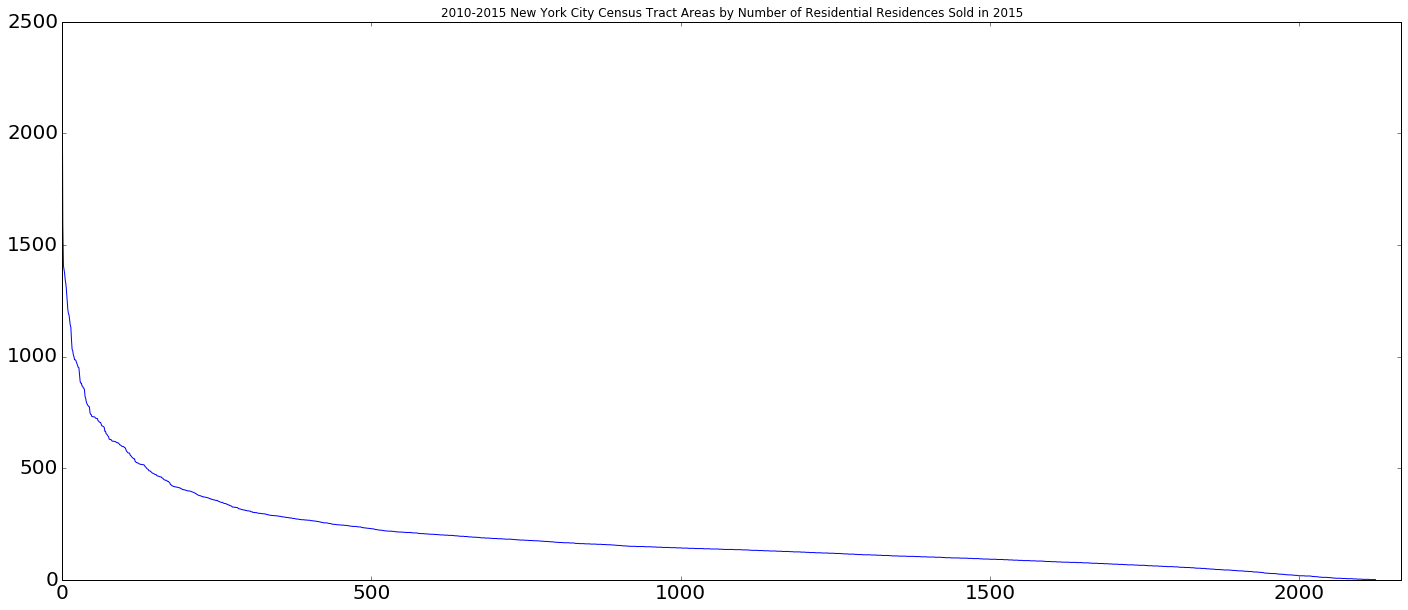

In [280]:
plotabble = p_df['Total'].sort_values(ascending=False)
plotabble.index = list(range(0, len(plotabble)))
plotabble.plot(figsize=(24, 10), title='2010-2015 New York City Census Tract Areas by Number of Residential Residences Sold in 2015', fontsize=20)

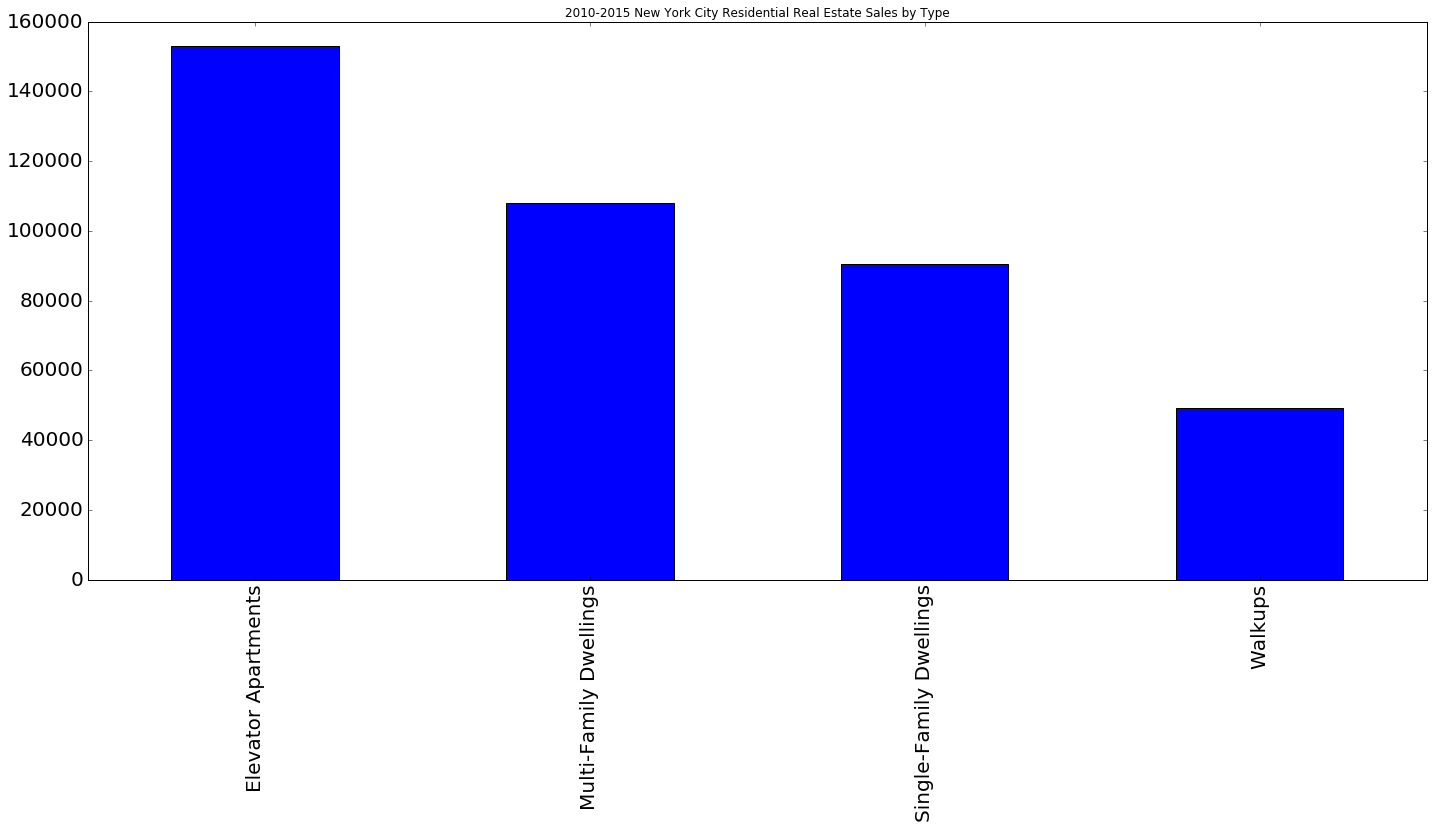

In [281]:
p_df.sum(axis='rows').sort_values(ascending=False).drop('Total').plot(kind='bar', figsize=(24, 10), fontsize=20, title='2010-2015 New York City Residential Real Estate Sales by Type')

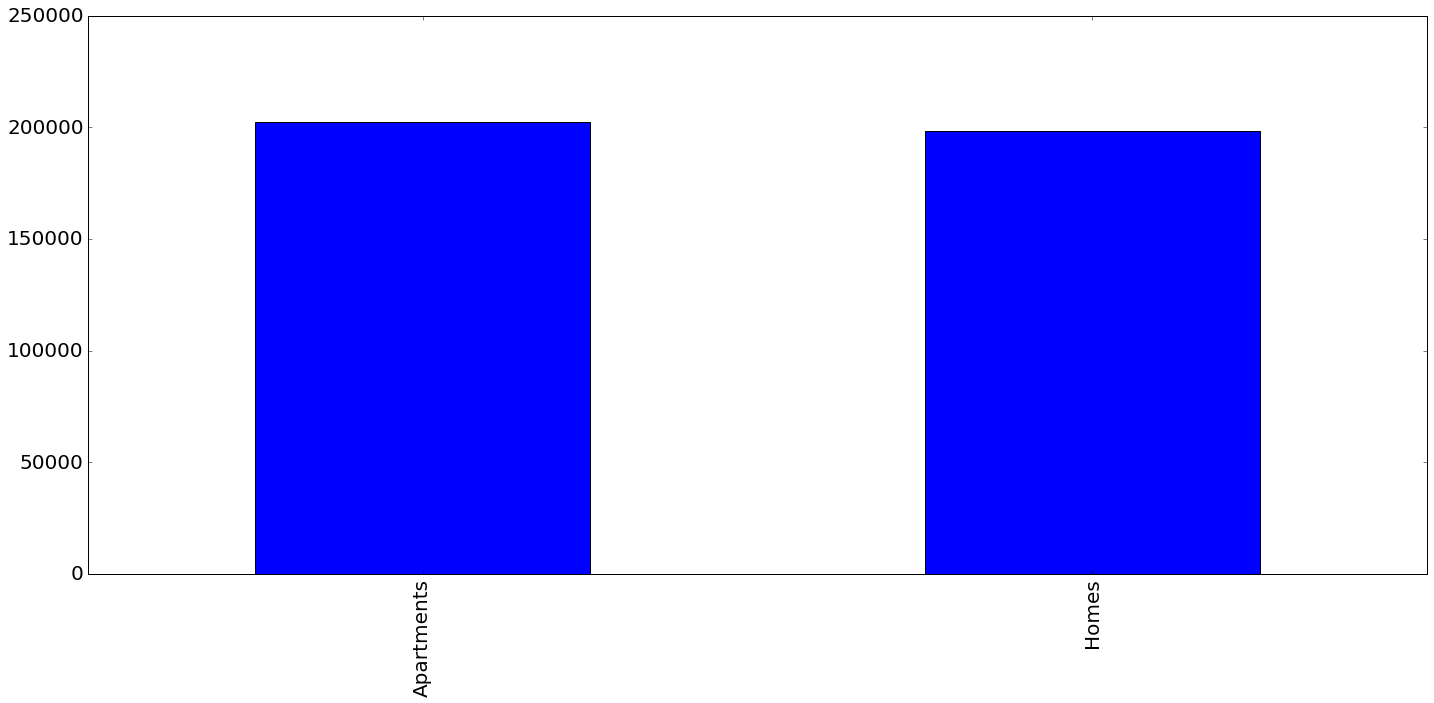

In [282]:
p_df.sum(axis='rows').sort_values(ascending=False).drop('Total').groupby(['Apartments','Homes','Homes','Apartments']).sum().plot(kind='bar', figsize=(24, 10), fontsize=20)

Things look good!

Occassionally we find polygons totally missing sales records. This makes sense, as there are plenty of census tracts enclosing parks, airports, and other such areas in which there is no real estate for sale (though interestingly these locations may still have a certain recorded population, from iterant/homeless individuals counted there).

We need to distinguish between areas which have `NaN` in a column because they contain a `NaN` in every column, e.g. they are non-residential; and areas which have a `NaN` in one column but have values filled in others.

To do this I apply a mask. But since we're removing `NaN`-ed values anyway we might as well also set a lower bound on the amount of sales that we have to have records of before we are willing to treat it as data, not noise.

In [352]:
len(p_df[p_df['Total'].notnull()])

2124

In [353]:
len(p_df[p_df['Total'] > 10])

2046

In [354]:
len(p_df)

2166

In [485]:
def mask(srs):
    if np.isnan(srs['Total']):
        pass
    elif srs['Total'] < 4:
        return np.nan
    else:
        return srs.fillna(0)

In [486]:
p_df_masked = p_df.apply(mask, axis='columns')

A cutoff of 4 seemed like the best compromise of performance versus accuracy. In particular 4 is the smallest cutoff which picks up La Guardia Airport.

The mask that I used casts records which have an insufficient number of entries to be considered complete, per the cut-off that we have set, to an `np.nan` recordset. In cases in which we have four or more sales on record but some of the columns are `np.nan`, because they were included in the count, the total for those columns is cast to 0 by `fillna(0)`.

Thus our output, `p_df_masked`, is a DataFrame containing the absolute counts for each of the four categories for which data is sufficient, and a row of `np.nan` for those records for which data is insufficient.

I want to be sure that the level that I set is correct, so I would like to map out the polygons that I am removing so I can visually inspect them. To do this I will use a library that I've been wanting to play around with `geopandas`, which has an adaptation of the `pandas` series that knows how to `plot()` itself cartographically. However, `geopandas` has `fiona` as a dependency, which (once again) doesn't install sucessfully via `pip`. So we use the now-familiar process of [looking up](http://www.lfd.uci.edu/~gohlke/pythonlibs/#fiona) its wheel and downloading that.

The limit that I set in mask is based on inspecting the outputted plot.

In [312]:
from geopandas import GeoSeries

In [487]:
null_polygons = GeoSeries([list_of_polygons[i] for i in p_df_masked[p_df_masked['Total'].isnull()].index.values])

In [488]:
ax = null_polygons.plot()
mplleaflet.show()

Next we convert this information to percentages.

In [494]:
p_p_df = pd.DataFrame()
p_p_df['Single-Family Dwellings, Ratio'] = p_df_masked['Single-Family Dwellings'] / p_df_masked['Total']
p_p_df['Multi-Family Dwellings, Ratio'] = p_df_masked['Multi-Family Dwellings'] / p_df_masked['Total']
p_p_df['Walkups, Ratio'] = p_df_masked['Walkups'] / p_df_masked['Total']
p_p_df['Elevator Apartments, Ratio'] = p_df_masked['Elevator Apartments'] / p_df_masked['Total']
p_p_df['Total'] = p_df_masked['Total']

`p_p_df` is the data that I want to associate with each polygon in the root GeoJSON or TopoJSON. TopoJSON features are listed in an indexed order; GeoJSON are too. Without a commanding reason to do otherwise, I assume that the conversion tool that I used mapped one index to the other. That is, if some polygon was the 4th polygon in the TopoJSON file, I assume that it is also the 4th polygon in the GeoJSON file.

Every polygonal object in [both a TopoJSON and] a GeoJSON has a `properties` key able to store JavaScript serial format information on that specific polygon. Therefore my next step is to associate each of the percentages with the TopoJSON format using the following notation:

    {properties: {'single': n, 'multi': n, 'walkup': n, 'elevator': n}}

The `json` library I will use for dumping the file will not convert the `np.nan` values into our dataset. So we need to convert these to `None` at runtime, which the `json` library will correctly map to the JavaScript `null` type. We couldn't do this beforehand because a `pandas` object automatically casts `None` to `np.nan`!

In [511]:
def pass_through(r):
    if np.isnan(r):
        return None
    else:
        return r

In [512]:
topo_geo = geojson.loads(open('census_tracts_2010.geojson', 'r').read())

In [514]:
geo_loaded = topo_geo.copy()
for i, feature in enumerate(geo_loaded['objects']['nyct2010']['geometries']):
#     print(pass_through(p_p_df['Single-Family Dwellings, Ratio'][i]))
    feature['properties'] = {
                                'single': pass_through(p_p_df['Single-Family Dwellings, Ratio'][i]),
                                'multi': pass_through(p_p_df['Multi-Family Dwellings, Ratio'][i]),
                                'walkup': pass_through(p_p_df['Walkups, Ratio'][i]),
                                'elevator': pass_through(p_p_df['Elevator Apartments, Ratio'][i])
                            }

`geo_loaded` is a GeoJSON file fully loaded with the ratio information that we want to use for our visualization. All that remains is saving `geo_loaded` to a file and then running the file through a TopoJSON converter. I enschewed using `ogr2ogr` for this conversion process, instead using the same online converter that got me the GeoJSON I was using throughout here in the first place.

In [173]:
import json

In [515]:
with open('real_estate_density.geojson', 'w') as file:
    file.write(json.dumps(geo_loaded, indent=4))

I validated that the file worked using [Mapshaper](http://www.mapshaper.org/) (awesome site). It did; and at that point this stage of the project is ended.